In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from snorkel.learning.pytorch import LSTM
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
dotenv.load_dotenv('../env.sh')
%matplotlib inline
%run ../src/supervision.py
session = SnorkelSession()

article_data_files = [
    osp.join(os.environ['IMPORT_DATA_DIR_01'], 'data.csv'),
    osp.join(os.environ['IMPORT_DATA_DIR_02'], 'data.csv')
]

# TODO:
# - top and bottom examples for each relation
# - word cloud by probability tier
# - top cytokines/tfs by cell type and paper count
# - top cytokines by cell type from immuneXpresso for comparison
# - top cytokines per cell type over time

## Generate Predictions

In [2]:
classes = get_candidate_classes()

res_pred = {}
#split = SPLIT_TRAIN
split = SPLIT_INFER

for c in classes:
    candidate_class = classes[c]
    X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == split).all()
    
    lstm = LSTM()
    lstm.load('lstm_' + candidate_class.field, osp.join(os.environ['MODEL_DATA_DIR'], 'lstm'))

    Y = lstm.marginals(X)
    res_pred[c] = X, Y, lstm

[LSTM] Loaded model <lstm_inducing_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_secreted_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_inducing_transcription_factor>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


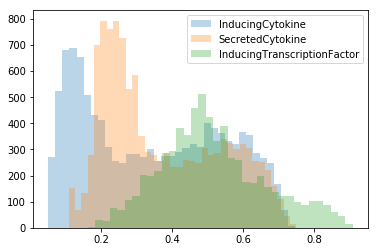

In [5]:
for c in res_pred:
    plt.hist(res_pred[c][1], label=c, bins=36, alpha=.3)
    plt.legend()

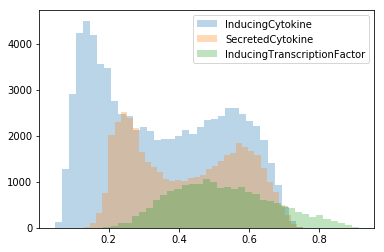

In [3]:
for c in res_pred:
    plt.hist(res_pred[c][1], label=c, bins=36, alpha=.3)
    plt.legend()

### Add Predictions to Candidates

In [4]:
df_ck = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cytokines.csv'))
df_ct = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cell_types.csv'))
df_tf = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'transcription_factors.csv'))

m_ct = df_ct.set_index('prefid')['lbl'].to_dict()
m_ck = df_ck.set_index('prefid')['lbl'].to_dict()
m_tf = df_tf.set_index('prefid')['lbl'].to_dict()

# Load doc id -> publishing date dict
m_doc_dt = {
    k: v
    for f in article_data_files
    for k, v in pd.read_csv(f, usecols=['id', 'date'])
    .assign(id=lambda df: 'PMC' + df['id'].astype(str))
    .pipe(lambda df: df[df['date'].notnull()])
    .assign(date=lambda df: pd.to_datetime(df['date']))
    .set_index('id')['date'].to_dict().items()
}

In [5]:
def to_record(cls, c, i, X, Y):
    assert len(X) == len(Y)
    candidate_class = classes[cls]
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == ENT_TYP_CK.lower():
        m1 = m_ck
    elif typs[0] == ENT_TYP_TF.lower():
        m1 = m_tf
    else:
        raise ValueError('Type "{}" not supported'.format(typs[0]))
    ent1_cid = getattr(c, typs[0] + '_cid')
    ent2_cid = getattr(c, typs[1] + '_cid')
    doc_id = c.get_parent().get_parent().name
    return {
        'type': candidate_class.field, 
        'date': m_doc_dt.get(doc_id, None),
        'doc_id': doc_id, 
        'candidate_id': c.id, 
        'ent1_text': getattr(c, typs[0]).get_span(),
        'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
        'ent1_cid': ent1_cid, 
        'ent2_text': getattr(c, typs[1]).get_span(),
        'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
        'ent2_cid': ent2_cid,
        'prob': Y[i]
    }

df = pd.DataFrame([
    to_record(cls, cand, i, res_pred[cls][0], res_pred[cls][1]) 
    for cls in res_pred
    for i, cand in enumerate(res_pred[cls][0])
])
df.head()

,candidate_id,date,doc_id,ent1_cid,ent1_lbl,ent1_text,ent2_cid,ent2_lbl,ent2_text,prob,type
0,31923,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.240373,inducing_cytokine
1,31924,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.605794,inducing_cytokine
2,31925,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.419859,inducing_cytokine
3,31926,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.648573,inducing_cytokine
4,31927,2017-07-21,PMC5686050,CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707,IL-4,IL-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.228279,inducing_cytokine


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138761 entries, 0 to 138760
Data columns (total 11 columns):
candidate_id    138761 non-null int64
date            138761 non-null datetime64[ns]
doc_id          138761 non-null object
ent1_cid        138761 non-null object
ent1_lbl        138761 non-null object
ent1_text       138761 non-null object
ent2_cid        138761 non-null object
ent2_lbl        138761 non-null object
ent2_text       138761 non-null object
prob            138761 non-null float64
type            138761 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 11.6+ MB


In [7]:
df['type'].value_counts()

inducing_cytokine                76639
secreted_cytokine                43664
inducing_transcription_factor    18458
Name: type, dtype: int64

In [8]:
df['ent2_lbl'].value_counts().sort_values().tail()

Th       6388
Th2     20855
Th1     22651
Treg    26167
Th17    31352
Name: ent2_lbl, dtype: int64

In [9]:
df['ent1_lbl'].value_counts().sort_values().tail()

IL-2      8380
IL-10     9530
TGF-β    10973
IL-4     11840
IFN-γ    15391
Name: ent1_lbl, dtype: int64

## Top Examples by Relation

In [11]:
def get_sentence_html(c, p=None):
    text = c.get_parent().text
    ctx = sorted(c.get_contexts(), key=lambda v: v.char_start)
    c0 = ctx[0].char_start, ctx[0].char_end+1
    c1 = ctx[1].char_start, ctx[1].char_end+1
    assert c0[0] < c1[0] and c0[1] < c1[0]
    
    parts = []
    if p is not None:
        parts += ['<a style="background-color: white">{:.2f}%|&nbsp;</a>'.format(p*100)]
    parts += [
        text[:c0[0]], '<font color="red"><strong>' + text[c0[0]:c0[1]] + '</strong></font>',
        text[c0[1]:c1[0]], '<font color="blue"><strong>' + text[c1[0]:c1[1]] + '</strong></font>',
        text[c1[1]:]
    ]
    return ''.join(parts)

In [32]:
from IPython.display import HTML, display

def get_prediction_html(index, X, Y, limit):
    html = []
    sent_ids = set()
    for i in index:
        sent_id = X[i].get_parent().id
        if sent_id in sent_ids:
            continue
        sent_ids.add(sent_id)
        html.append(get_sentence_html(X[i], p=Y[i]))
        if len(html) >= limit:
            break
    return HTML('<br>\n'.join(html))
    
limit = 10
res_pred_html = {}
for c in res_pred:
    X, Y = res_pred[c][:2]
    o = np.argsort(Y)
    res_pred_html[c] = {}
    
    display(HTML('<hr>'))
    print('%s (Top %s Highest Predictions):' % (c, limit))
    res_pred_html[c]['hi'] = get_prediction_html(o[::-1], X, Y, limit)
    display(res_pred_html[c]['hi'])
    
    display(HTML('<hr>'))
    print('%s (Mid %s Predictions):' % (c, limit))
    mid = len(o)//2
    res_pred_html[c]['mid'] = get_prediction_html(o[(mid-limit):(mid+limit)], X, Y, limit)
    display(res_pred_html[c]['mid'])
    
    display(HTML('<hr>'))
    print('%s (Bottom %s Lowest Predictions):' % (c, limit))
    res_pred_html[c]['lo'] = get_prediction_html(o, X, Y, limit)
    display(res_pred_html[c]['lo'])

InducingCytokine (Top 10 Highest Predictions):


InducingCytokine (Mid 10 Predictions):


InducingCytokine (Bottom 10 Lowest Predictions):


SecretedCytokine (Top 10 Highest Predictions):


SecretedCytokine (Mid 10 Predictions):


SecretedCytokine (Bottom 10 Lowest Predictions):


InducingTranscriptionFactor (Top 10 Highest Predictions):


InducingTranscriptionFactor (Mid 10 Predictions):


InducingTranscriptionFactor (Bottom 10 Lowest Predictions):


In [35]:
text = BeautifulSoup(res_pred_html['InducingCytokine']['hi'].data).get_text()
print(clean_text(text))

77.39%| IL-6 induces the differentiation of Th17from naïve Tthrough STAT3
76.59%| Nevertheless, the involvement of p38 MAPK in GITRL induced Th17differentiation has not been described.
75.46%| IL-18BP is decreased in osteoporotic women: Prevents Inflammasome mediated IL-18 Activation and reduces Th17 differentiation.
75.40%| Another study in mice further indicated that IL-23 was required for driving terminal Th17 differentiation .
74.91%| IL-25 promotes Th2differentiation in an IL-4-dependent manner.
74.76%| In addition, leptin receptor deficiency in Tinhibits Th17 differentiation and improves the insulin sensitivity in T-HGK cKO mice, which suggests that leptin cooperates with IL-6 to promote Th17 differentiation.
74.42%| The preferential effect of IL-2 on regulatory Tcontained among the CD4+ Tcould at least partially explain the discrepancies between mouse systems and these clinical results, and help to design improved approaches
74.37%| Enhanced Th2 development may be due to the sup

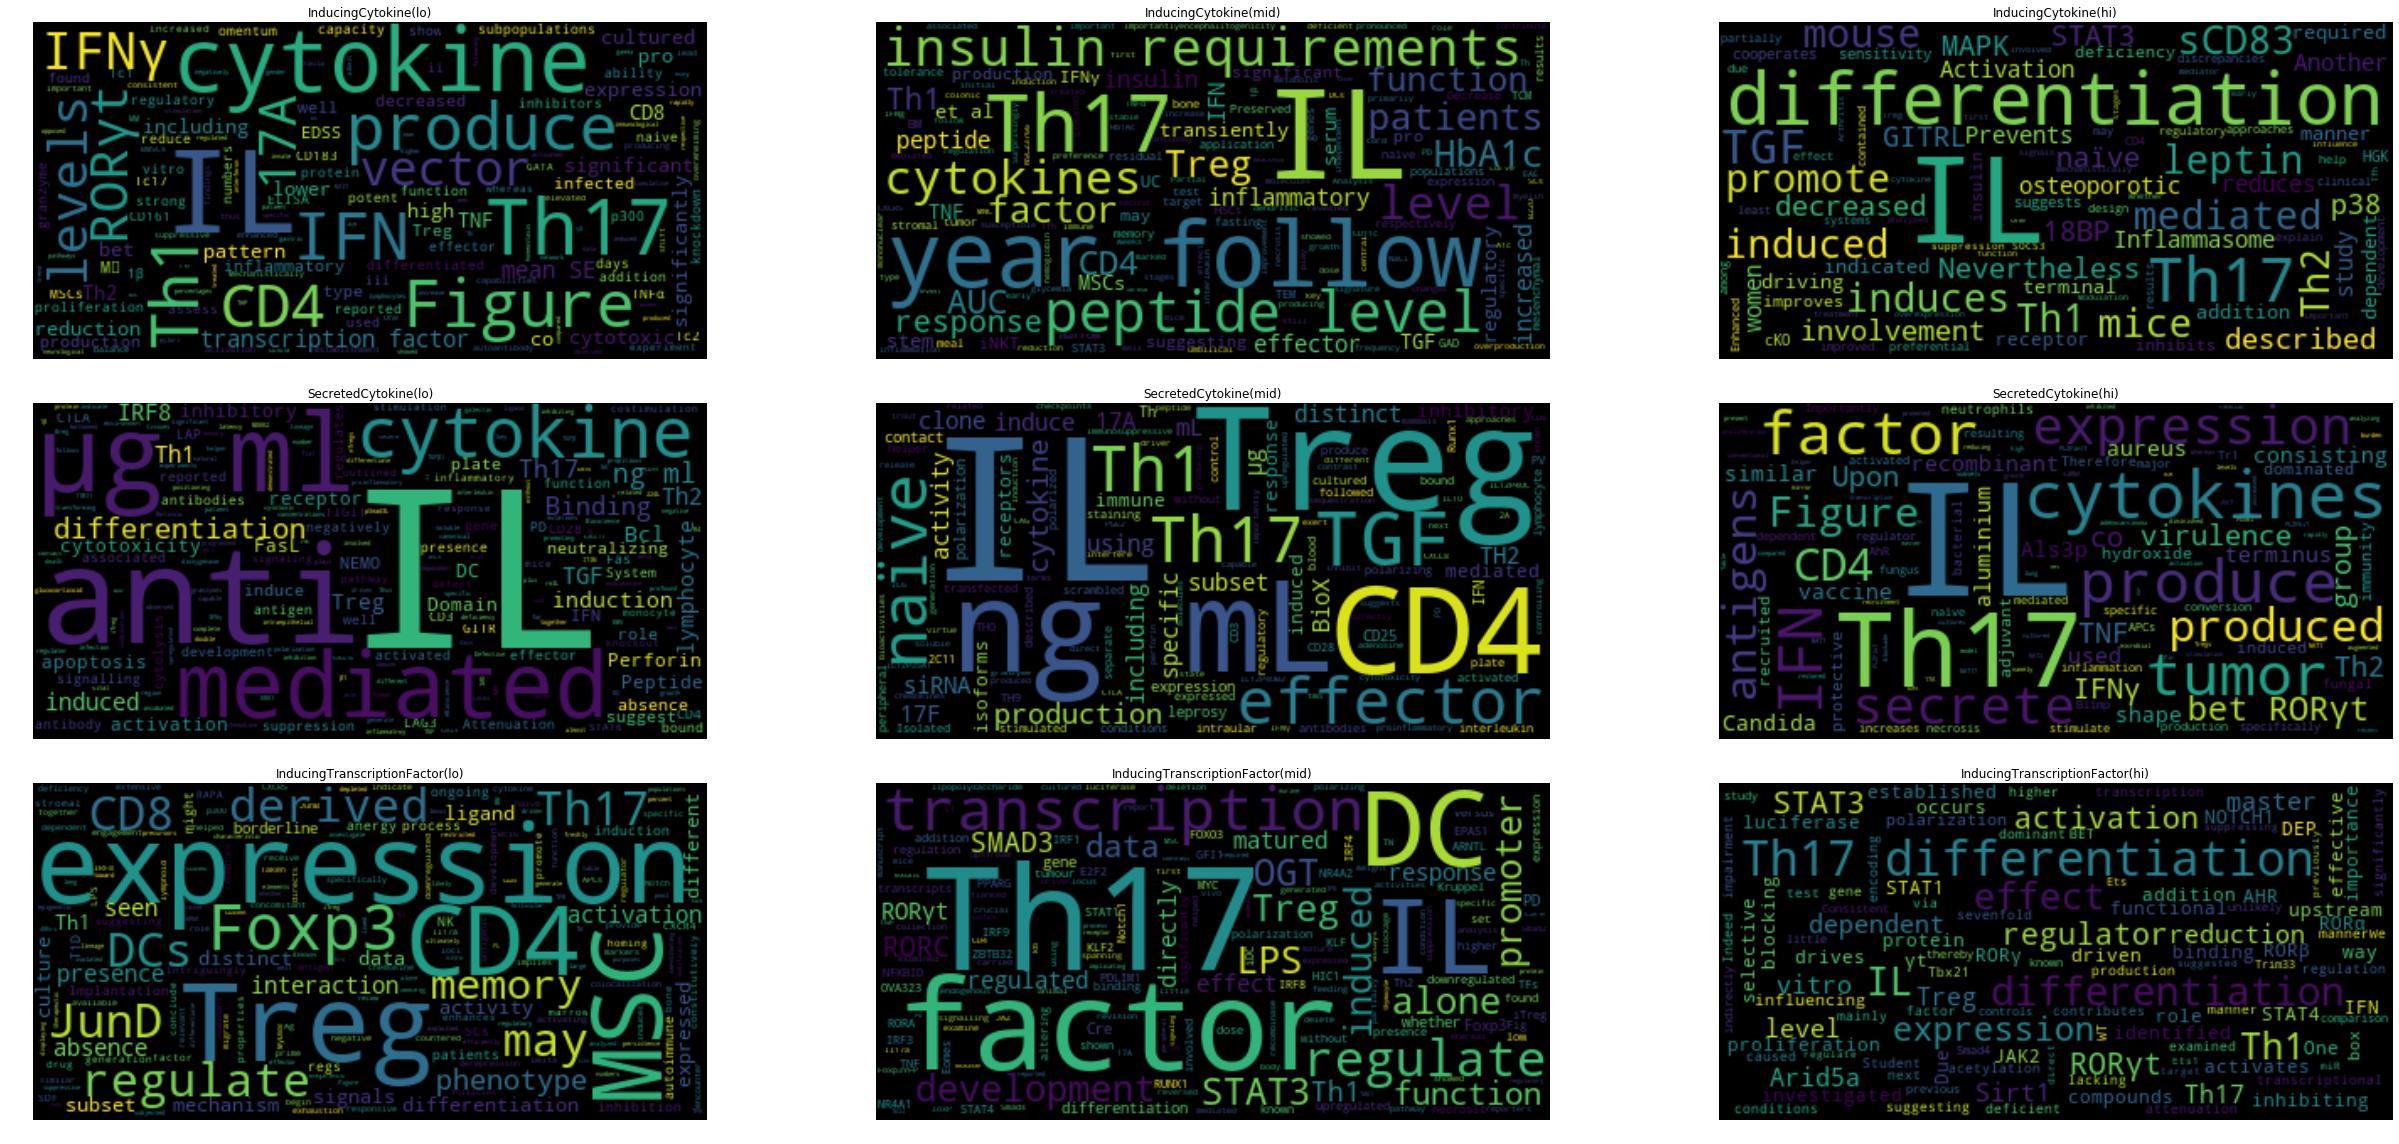

In [38]:
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
fig, axs = plt.subplots(len(res_pred_html), 3)
fig.set_size_inches(36, 16)

def remove_common_words(text):
    text = re.sub(r'cell[s]?', '', text, flags=re.I)
    return text
    
for i, c in enumerate(res_pred_html):
    def add_cloud(j, k):
        text = BeautifulSoup(res_pred_html[c][k].data).get_text()
        text = remove_common_words(text)
        wordcloud = WordCloud().generate(text)    
        axs[i, j].imshow(wordcloud, interpolation='bilinear')
        axs[i, j].axis("off")
        axs[i, j].set_title(c + '(' + k + ')')
    for j, k in enumerate(['lo', 'mid', 'hi']):
        add_cloud(j, k)
fig.tight_layout()

In [12]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

## Top Cytokines/TFs by Cell Type

"Enrichment Score": Proportion of papers for a cell type mentioning cytokine/TF divided by same proportion across all **other** cell types

In [39]:
def calculate_scores(df):
    
    def doc_ct(df):
        return df.groupby('ent1_lbl')['doc_id'].nunique().rename('uniq_doc_n')
    
    dfr = []
    for typ in df['type'].unique():
        for ct in df['ent2_lbl'].unique():
            df_tgt = df[(df['type'] == typ) & (df['ent2_lbl'] == ct)]
            df_ctx = df[(df['type'] == typ)]
            dfr.append(
                pd.merge(
                    # Unique doc counts for cell type (tgt) by cytokine/TF 
                    # as well as by cytokine/TF for all cell types (ctx)
                    doc_ct(df_ctx).rename('uniq_docn_ctx').reset_index(),
                    doc_ct(df_tgt).rename('uniq_docn_tgt').reset_index(),
                    on='ent1_lbl',
                    how='outer'
                )
                .fillna(0)
                .assign(
                    type=typ, ent2_lbl=ct,
                    # Unique doc count for cell type (tgt) and all cell types (ctx)
                    uniq_docn_ct_ctx=df_ctx['doc_id'].nunique(),
                    uniq_docn_ct_tgt=df_tgt['doc_id'].nunique()
                )
            )
    dfr = pd.concat(dfr, sort=False)
    assert dfr.notnull().all().all()
    dfr['escore'] = (dfr['uniq_docn_tgt'] / dfr['uniq_docn_ct_tgt']) / (dfr['uniq_docn_ctx'] / dfr['uniq_docn_ct_ctx'])
    return dfr
            

dfp = calculate_scores(df.query('prob > .5'))

dfp.head()

,ent1_lbl,uniq_docn_ctx,uniq_docn_tgt,type,ent2_lbl,uniq_docn_ct_ctx,uniq_docn_ct_tgt,escore
0,4-1BB,10,2.0,inducing_cytokine,Th1,2056,961,0.427888
1,4-1BBL,1,0.0,inducing_cytokine,Th1,2056,961,0.000000
2,APRIL,6,2.0,inducing_cytokine,Th1,2056,961,0.713146
3,CCL1,5,0.0,inducing_cytokine,Th1,2056,961,0.000000
4,CCL11,2,0.0,inducing_cytokine,Th1,2056,961,0.000000


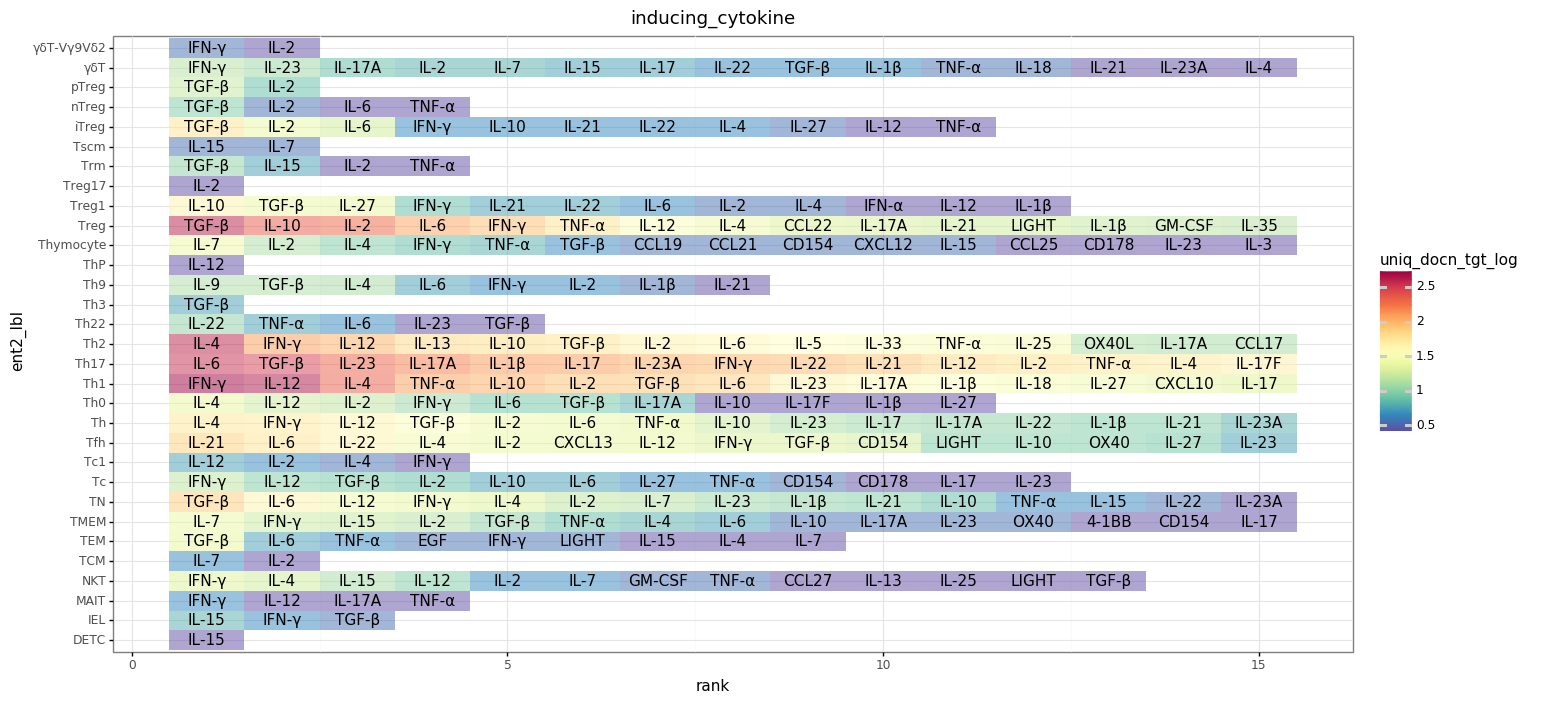

<ggplot: (-9223372036450026748)>

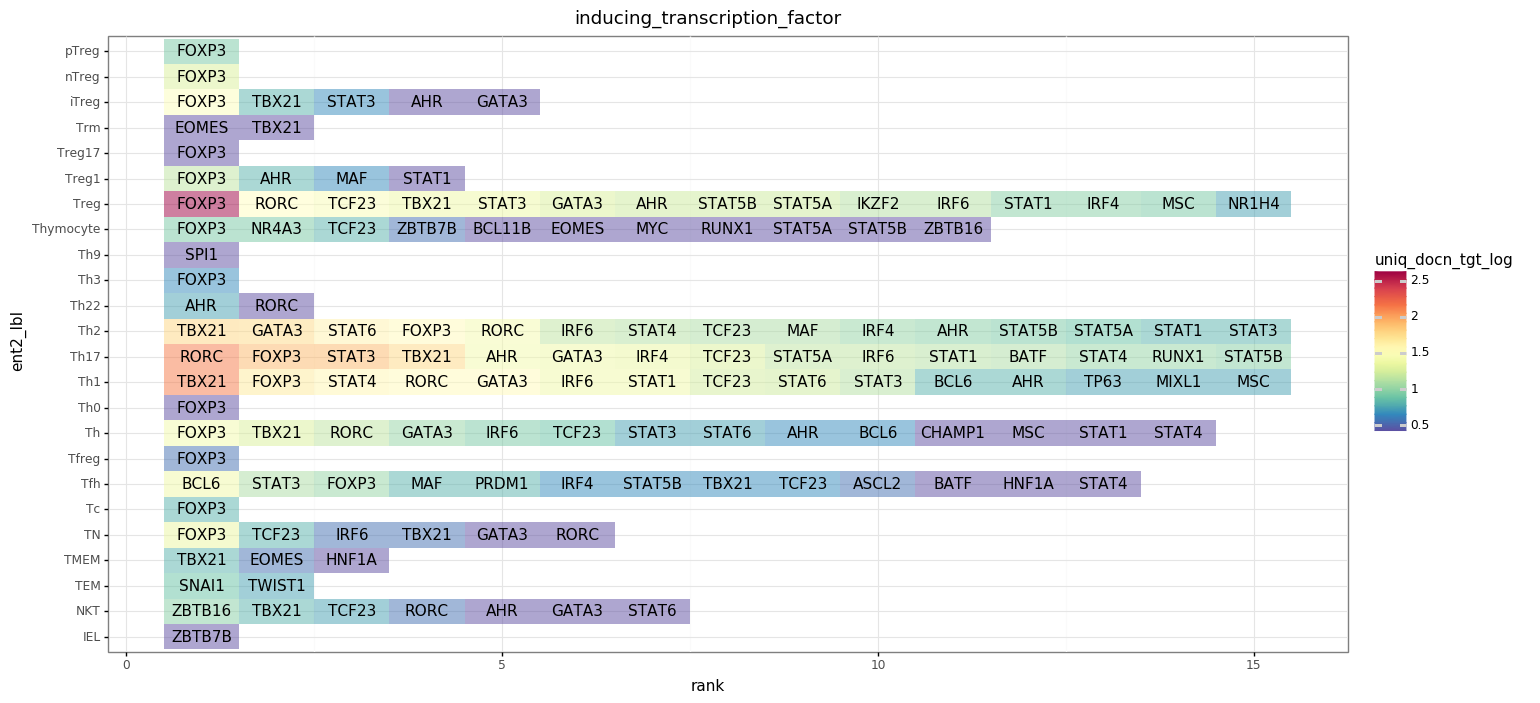

<ggplot: (405562074)>

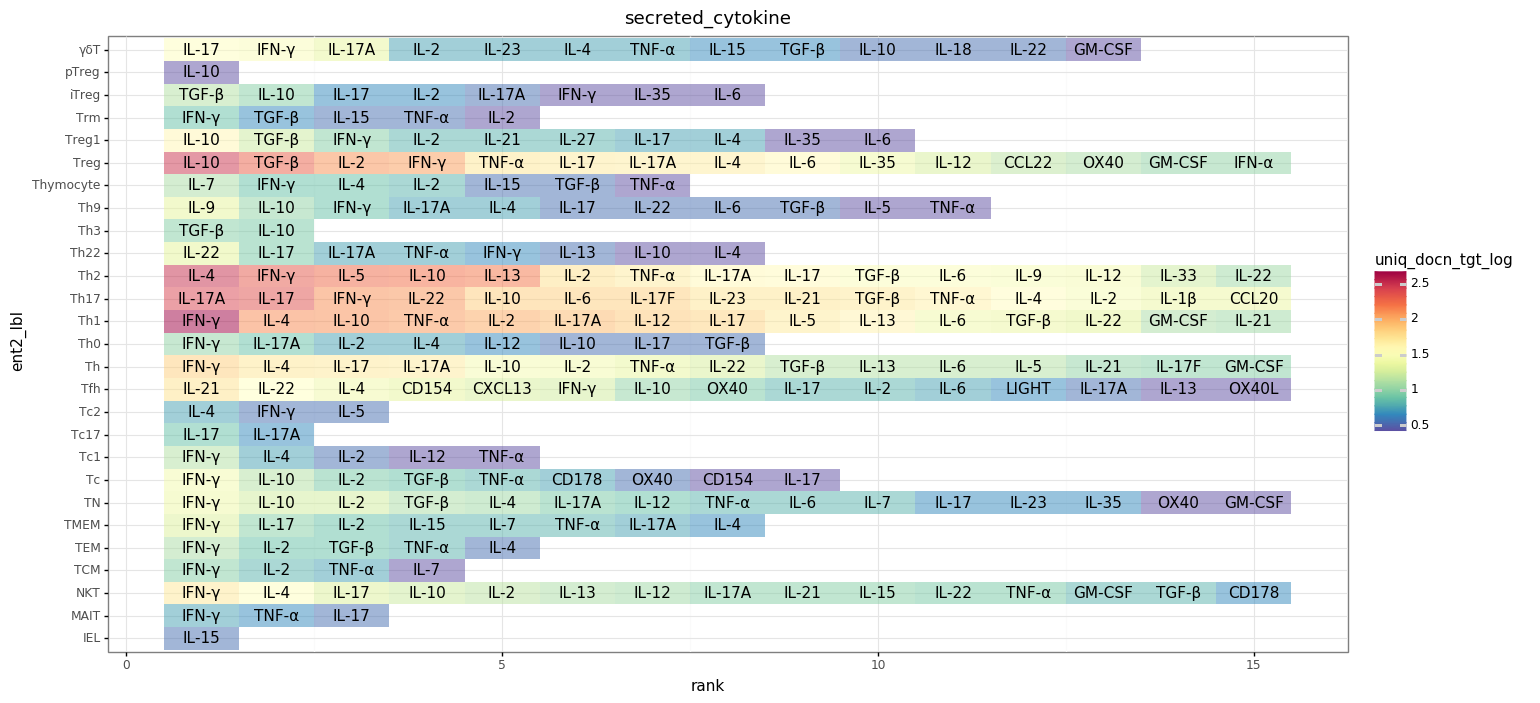

<ggplot: (406432022)>

In [46]:
 for k, g in dfp.query('uniq_docn_tgt >= 3').groupby('type'):
    p = (
        pn.ggplot(
            g
            .assign(uniq_docn_tgt_log=np.log10(g['uniq_docn_tgt']))
            .groupby('ent2_lbl').apply(
                lambda g: g.sort_values('uniq_docn_tgt_log', ascending=False)
                .assign(rank=np.arange(1, len(g)+1)).head(15)
            ),
            pn.aes(x='rank', y='ent2_lbl', fill='uniq_docn_tgt_log', label='ent1_lbl')
        ) + 
        pn.geom_tile(alpha=.5) +
        pn.scale_fill_cmap('Spectral_r') +
        pn.geom_text(color='black', alpha=1) +
        pn.ggtitle(k) +
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 8))
    )
    display(p)

In [47]:
# for k, g in dfp.groupby('type'):
#     p = (
#         pn.ggplot(g, pn.aes(x='ent1_lbl', y='uniq_doc_ct')) + 
#         pn.geom_bar(stat='identity', alpha=.3) +
#         pn.facet_wrap('~ ent2_lbl', scales='free', ncol=3, shrink=False) + 
#         pn.labs(title=k) + 
#         pn.coord_flip() +
#         pn.theme_bw() +
#         pn.theme(
#             axis_text_x = pn.element_text(angle = 90, hjust = 0),
#             figure_size=(16, 24)
#         )
#     )
#     display(p)

## Evolution over Time

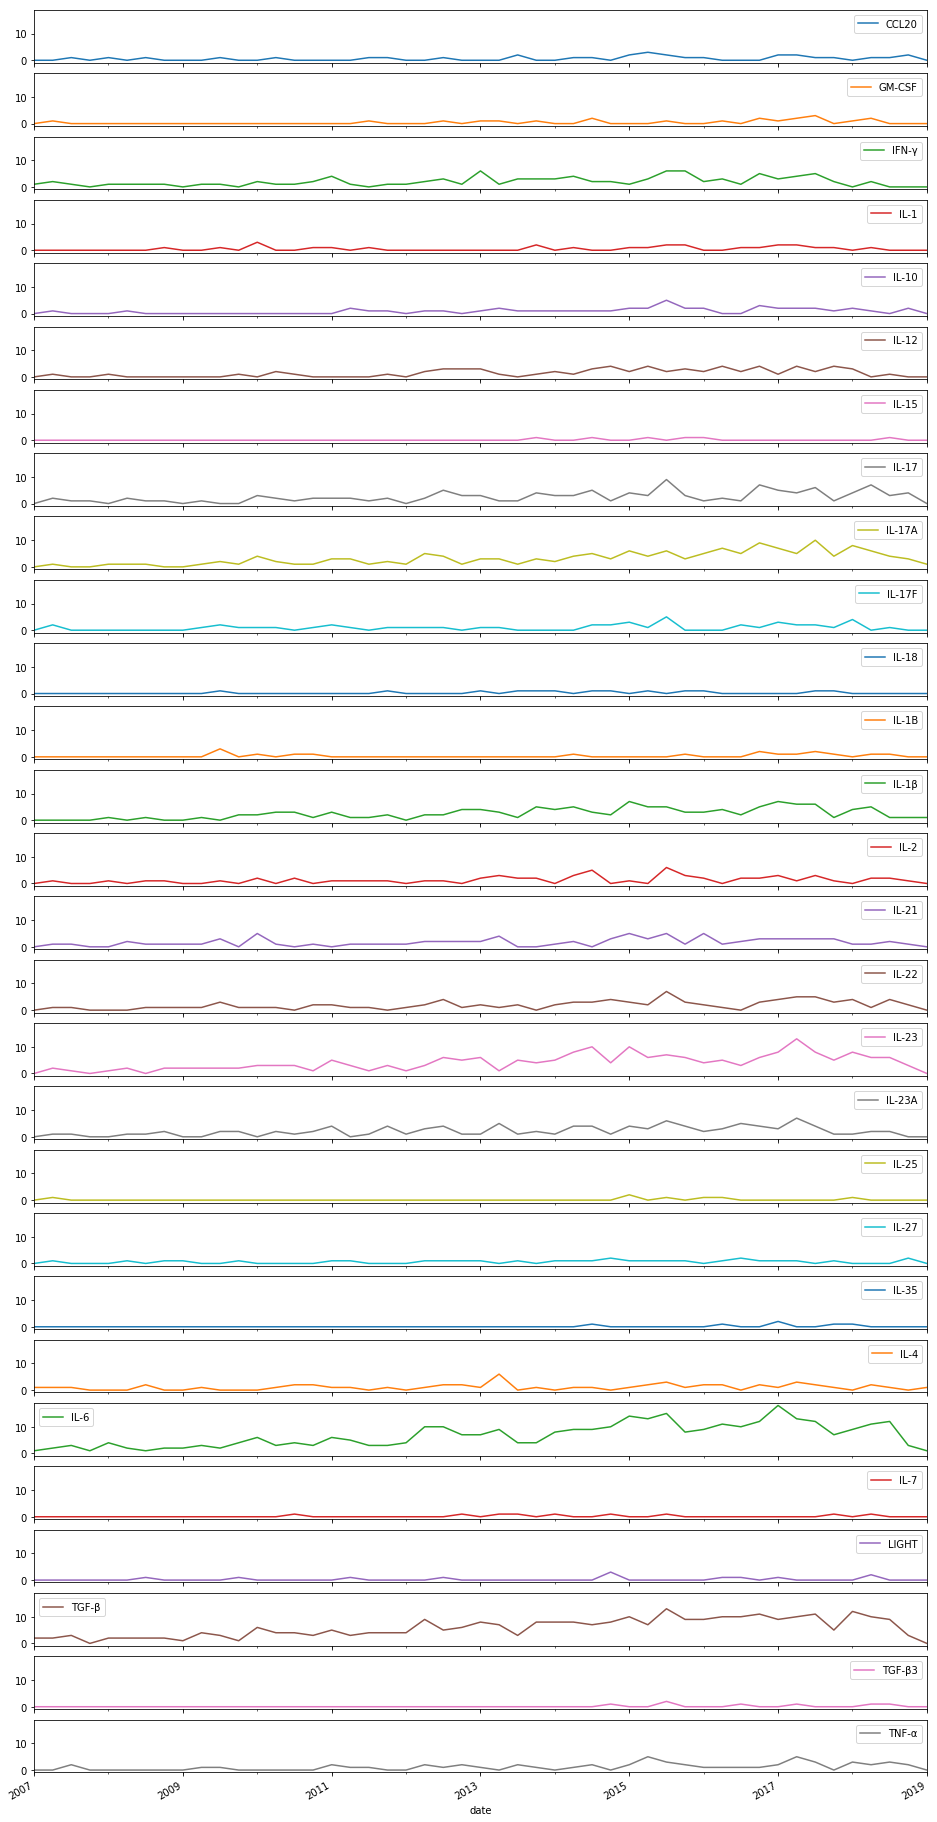

In [51]:
def remove_small_groups(df):
    cts = df.groupby('ent1_lbl')['count'].sum()
    return df[df['ent1_lbl'].isin(cts[cts > 5].index)]

(
    #df.query('prob > .5 & ent2_lbl == "Th17" & type == "secreted_cytokine"')
    df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_cytokine"')
    #df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_transcription_factor"')
    .groupby(['ent1_lbl', pd.Grouper(key='date', freq='1Q')])['doc_id'].nunique()
    .rename('count').reset_index()
    .pipe(remove_small_groups)
    .pivot(index='date', columns='ent1_lbl', values='count')
    .fillna(0)
    .plot(figsize=(16,36), subplots=True, sharey=True)
)
None

## ImmuneXpresso Comparison

In [52]:
def get_ix_data():
    df = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))
    df['type'] = None
    df['type'] = np.where(
        (df['actor'] == 'cell') & (df['category'] == 'Positive'), 
        classes.secreted_cytokine.field, 
        df['type']
    )
    df['type'] = np.where(
        (df['actor'] == 'cytokine') & (df['category'] == 'Positive'), 
        classes.inducing_cytokine.field, 
        df['type']
    )
    return df[df['type'].notnull()]
df_ix = get_ix_data()
df_ix.head()

,actor,category,cell_id,cell_label,cytokine_id,cytokine_label,num_papers,score,cell_ref_id,cytokine_ref_id,type
0,cell,Positive,CL_0000084,T cell,CID_83,IFNG,809,4.28,NaN,CK128EC732B281BF60,secreted_cytokine
1,cell,Positive,CL_0000084,T cell,CID_110,IL2,701,5.30,NaN,CKD21834C7D75FD77F,secreted_cytokine
2,cell,Positive,CL_0000625,"CD8-positive, alpha-beta T cell",CID_83,IFNG,338,8.88,NaN,CK128EC732B281BF60,secreted_cytokine
3,cytokine,Positive,CL_0000084,T cell,CID_110,IL2,313,1.58,NaN,CKD21834C7D75FD77F,inducing_cytokine
5,cell,Positive,CL_0000624,"CD4-positive, alpha-beta T cell",CID_83,IFNG,236,5.41,NaN,CK128EC732B281BF60,secreted_cytokine


In [53]:
df_comp = pd.merge((
        df
        .query('prob > .5')
        .assign(ent1_cid=lambda df: df['ent1_cid'].str.split(':').str[1])
        .assign(ent2_cid=lambda df: df['ent2_cid'].str.split(':').str[1])
        .groupby(['type', 'ent1_cid', 'ent1_lbl', 'ent2_cid', 'ent2_lbl'])['doc_id'].nunique()
        .rename('n_docs_snkl').reset_index()
    ), (
        df_ix.groupby(['type', 'cell_ref_id', 'cytokine_ref_id'])['num_papers'].max()
        .rename('n_docs_imxp').reset_index()
        .rename(columns={'cytokine_ref_id': 'ent1_cid', 'cell_ref_id': 'ent2_cid'})
    ),
    on=['type', 'ent1_cid', 'ent2_cid'],
    how='outer'
)
df_comp.head()

,type,ent1_cid,ent1_lbl,ent2_cid,ent2_lbl,n_docs_snkl,n_docs_imxp
0,inducing_cytokine,CK07DD580A35CC46A7,IL-18BP,CTBFBDE5121B6748D1,Th17,1.0,NaN
1,inducing_cytokine,CK07DD580A35CC46A7,IL-18BP,CTC3A8C3CBC245616A,Th1,1.0,NaN
2,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CT19D812F7CB34BCF6,iTreg,1.0,NaN
3,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CT1C58993C5B5BD3B8,TMEM,4.0,NaN
4,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CT22416FE03B9D6C99,IEL,2.0,NaN


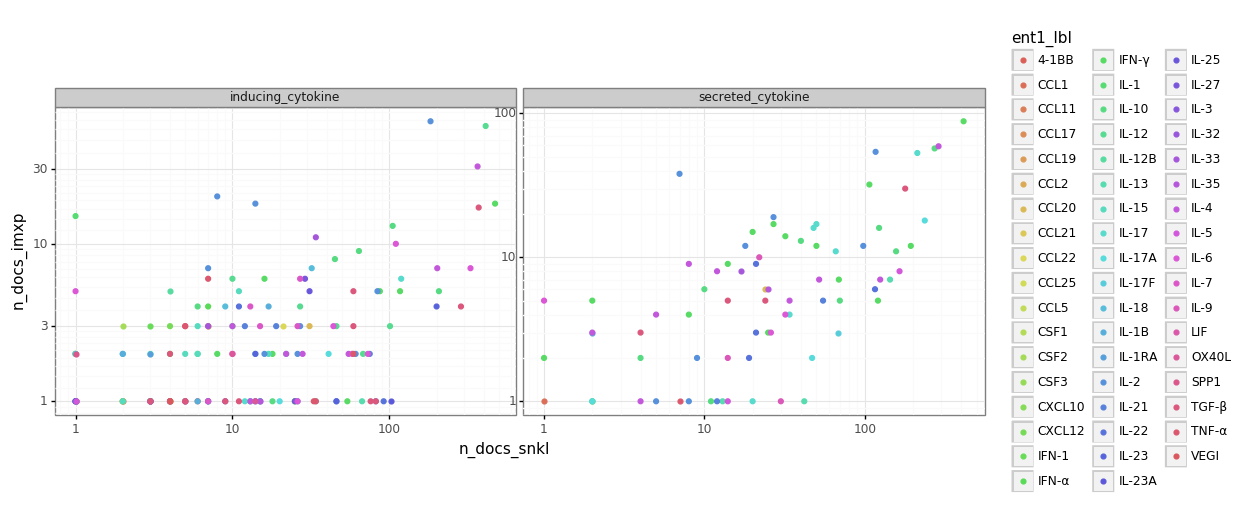

<ggplot: (388366007)>

In [54]:
(
    pn.ggplot(
        df_comp.dropna(), 
        pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent1_lbl')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~type', scales='free') + 
    pn.scale_x_log10() +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(12,4))
)

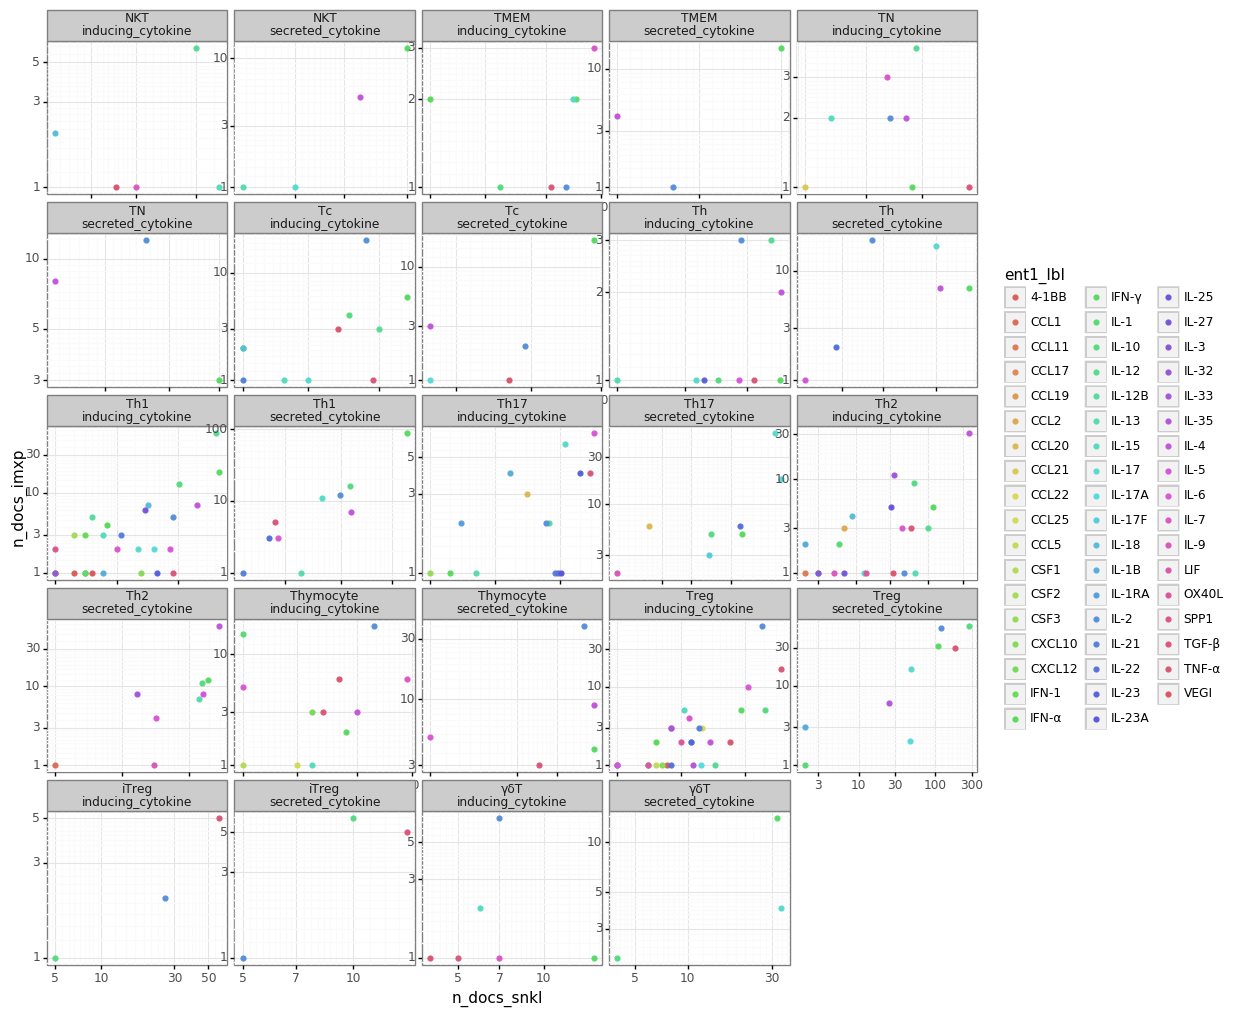

<ggplot: (389601116)>

In [55]:
cts = df_comp.dropna().groupby('ent2_lbl').size() 
(
    pn.ggplot(
        df_comp.dropna().pipe(lambda df: df[df['ent2_lbl'].isin(cts[cts > 5].index)]), 
        pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent1_lbl')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~ ent2_lbl + type', scales='free') + 
    pn.scale_x_log10() +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(12,12))
)

### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    candidate_class.field + '_low': 'color:red',
    candidate_class.field + '_mid': 'color:orange',
    candidate_class.field + '_high': 'color:green'
}, include_entity_text=False)